In [1]:
!pip install -q rfdetr supervision roboflow pycocotools tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 10.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.8/372.8 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
from roboflow import Roboflow
import json
from collections import Counter

In [4]:
BASE_DIR = "/content/drive/MyDrive/rfdetr-coins"
CHECKPOINT_DIR = f"{BASE_DIR}/checkpoints"
LOG_DIR = f"{BASE_DIR}/logs"
PRED_DIR = f"{BASE_DIR}/predictions"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(PRED_DIR, exist_ok=True)

In [5]:
from google.colab import userdata
key = userdata.get('ROBOFLOW_API_KEY')

In [6]:
rf = Roboflow(api_key=key)

In [7]:
project = rf.workspace("amit-singh-2q3dg").project("coins-mio6z")
dataset = project.version(1).download('coco', location='/content/coins')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/coins in coco:: 100%|██████████| 240/240 [00:00<00:00, 6576.42it/s]


In [8]:
with open('/content/coins/train/_annotations.coco.json', 'r') as f:
  coco = json.load(f)

print("Images:", len(coco["images"]))
print("Annotations:", len(coco["annotations"]))
print("Classes:", [c["name"] for c in coco["categories"]])

Images: 162
Annotations: 155
Classes: ['coins', '1', '2', '5', '10', '20']


In [9]:
coco.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [10]:
classes = [cat['name'] for cat in coco['categories']]
print('classes:', classes)

classes: ['coins', '1', '2', '5', '10', '20']


In [11]:
labels = [ann["category_id"] for ann in coco["annotations"]]
print("Class distribution:", Counter(labels))

Class distribution: Counter({5: 44, 2: 39, 1: 28, 3: 23, 4: 21})


In [12]:
import random
import cv2
import matplotlib.pyplot as plt

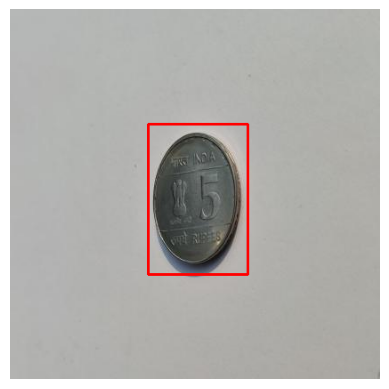

In [13]:
img = random.choice(coco["images"])
img_path = f"/content/coins/train/{img['file_name']}"
image = cv2.imread(img_path)

if image is None:
    print(f"Error: Could not load image from {img_path}")
else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    anns = [a for a in coco["annotations"] if a["image_id"] == img["id"]]
    for ann in anns:
        x, y, w, h = map(int, ann["bbox"])
        cv2.rectangle(image, (x,y), (x+w,y+h), (255,0,0), 2)

    plt.imshow(image)
    plt.axis("off")

In [14]:
import torch
from rfdetr import RFDETRSmall

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
torch.cuda.memory_allocated() / 1024**2  #MB

0.0

In [ ]:
model = RFDETRSmall()

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


In [ ]:
torch.cuda.memory_allocated() / 1024**2  #MB

122.56982421875

In [ ]:
TRAIN_DATA_DIR = "/content/coins/"
VAL_DATA_DIR = "/content/coins/"

In [ ]:
model.train(
    dataset_dir=TRAIN_DATA_DIR,
    epochs=30,
    batch_size=2,
    grad_accum_steps=8,
    resolution=640,
    lr=1e-4,
    output_dir=CHECKPOINT_DIR,
    early_stopping=True,
    device=device,
    early_stopping_patience=9,
    use_ema=True,
    checkpoint_interval=5,
    fp16=True,
    tensorboard=False
)


Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=6, grad_accum_steps=8, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=2, weight_decay=0.0001, epochs=30, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-small.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=3, dim_feedforward=2048, hidden_dim=256, sa_nheads=8, ca_nheads=16, num_queries=300, group_detr=13, two_stage=True, projector_scale=['P4'], lite_refpoint_refine=True, num_select=300, dec_n_poi

Epoch: [0]  [ 0/10]  eta: 0:01:31  lr: 0.000100  class_error: 53.85  loss: 8.2193 (8.2193)  loss_ce: 1.2471 (1.2471)  loss_bbox: 0.4656 (0.4656)  loss_giou: 0.3905 (0.3905)  loss_ce_0: 1.2268 (1.2268)  loss_bbox_0: 0.3714 (0.3714)  loss_giou_0: 0.3430 (0.3430)  loss_ce_1: 1.2371 (1.2371)  loss_bbox_1: 0.4831 (0.4831)  loss_giou_1: 0.4091 (0.4091)  loss_ce_enc: 1.2324 (1.2324)  loss_bbox_enc: 0.4259 (0.4259)  loss_giou_enc: 0.3872 (0.3872)  loss_ce_unscaled: 1.2471 (1.2471)  class_error_unscaled: 53.8462 (53.8462)  loss_bbox_unscaled: 0.0931 (0.0931)  loss_giou_unscaled: 0.1953 (0.1953)  cardinality_error_unscaled: 3792.0000 (3792.0000)  loss_ce_0_unscaled: 1.2268 (1.2268)  loss_bbox_0_unscaled: 0.0743 (0.0743)  loss_giou_0_unscaled: 0.1715 (0.1715)  cardinality_error_0_unscaled: 3203.5000 (3203.5000)  loss_ce_1_unscaled: 1.2371 (1.2371)  loss_bbox_1_unscaled: 0.0966 (0.0966)  loss_giou_1_unscaled: 0.2046 (0.2046)  cardinality_error_1_unscaled: 3681.5000 (3681.5000)  loss_ce_enc_unscale

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import json

In [ ]:
with open(f"{CHECKPOINT_DIR}/results.json", 'r') as f:
  results = json.load(f)

In [ ]:
results

{'class_map': {'valid': [{'class': '1',
    'map@50:95': 0.86626812044023,
    'map@50': 1.0,
    'precision': 1.0,
    'recall': 0.75},
   {'class': '2',
    'map@50:95': 0.5986798679867987,
    'map@50': 0.693069306930693,
    'precision': 0.8333333333333334,
    'recall': 0.75},
   {'class': '5',
    'map@50:95': 0.6525035466787489,
    'map@50': 0.7650023066822814,
    'precision': 0.6666666666666666,
    'recall': 0.75},
   {'class': '10',
    'map@50:95': 0.897029702970297,
    'map@50': 1.0,
    'precision': 1.0,
    'recall': 0.75},
   {'class': '20',
    'map@50:95': 0.7510599146533917,
    'map@50': 0.9210638710929916,
    'precision': 0.9333333333333333,
    'recall': 0.75},
   {'class': 'all',
    'map@50:95': 0.7531082305458933,
    'map@50': 0.8758270969411932,
    'precision': 0.8866666666666667,
    'recall': 0.75}],
  'test': [{'class': '1',
    'map@50:95': 0.8232095709570957,
    'map@50': 1.0,
    'precision': 1.0,
    'recall': 1.0},
   {'class': '2',
    'map@50:9

In [ ]:
test_metrics = results["class_map"]["test"]

classes = []
map50 = []
map5095 = []
precision = []
recall = []

for entry in test_metrics:
    if entry["class"] == "all":
        continue
    classes.append(entry["class"])
    map50.append(entry["map@50"])
    map5095.append(entry["map@50:95"])
    precision.append(entry["precision"])
    recall.append(entry["recall"])


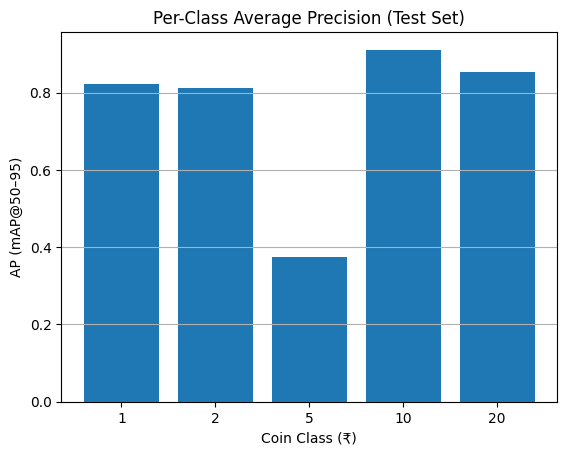

In [ ]:
plt.figure()
plt.bar(classes, map5095)
plt.xlabel("Coin Class (₹)")
plt.ylabel("AP (mAP@50–95)")
plt.title("Per-Class Average Precision (Test Set)")
plt.grid(axis="y")
plt.show()

In [ ]:
from PIL import Image

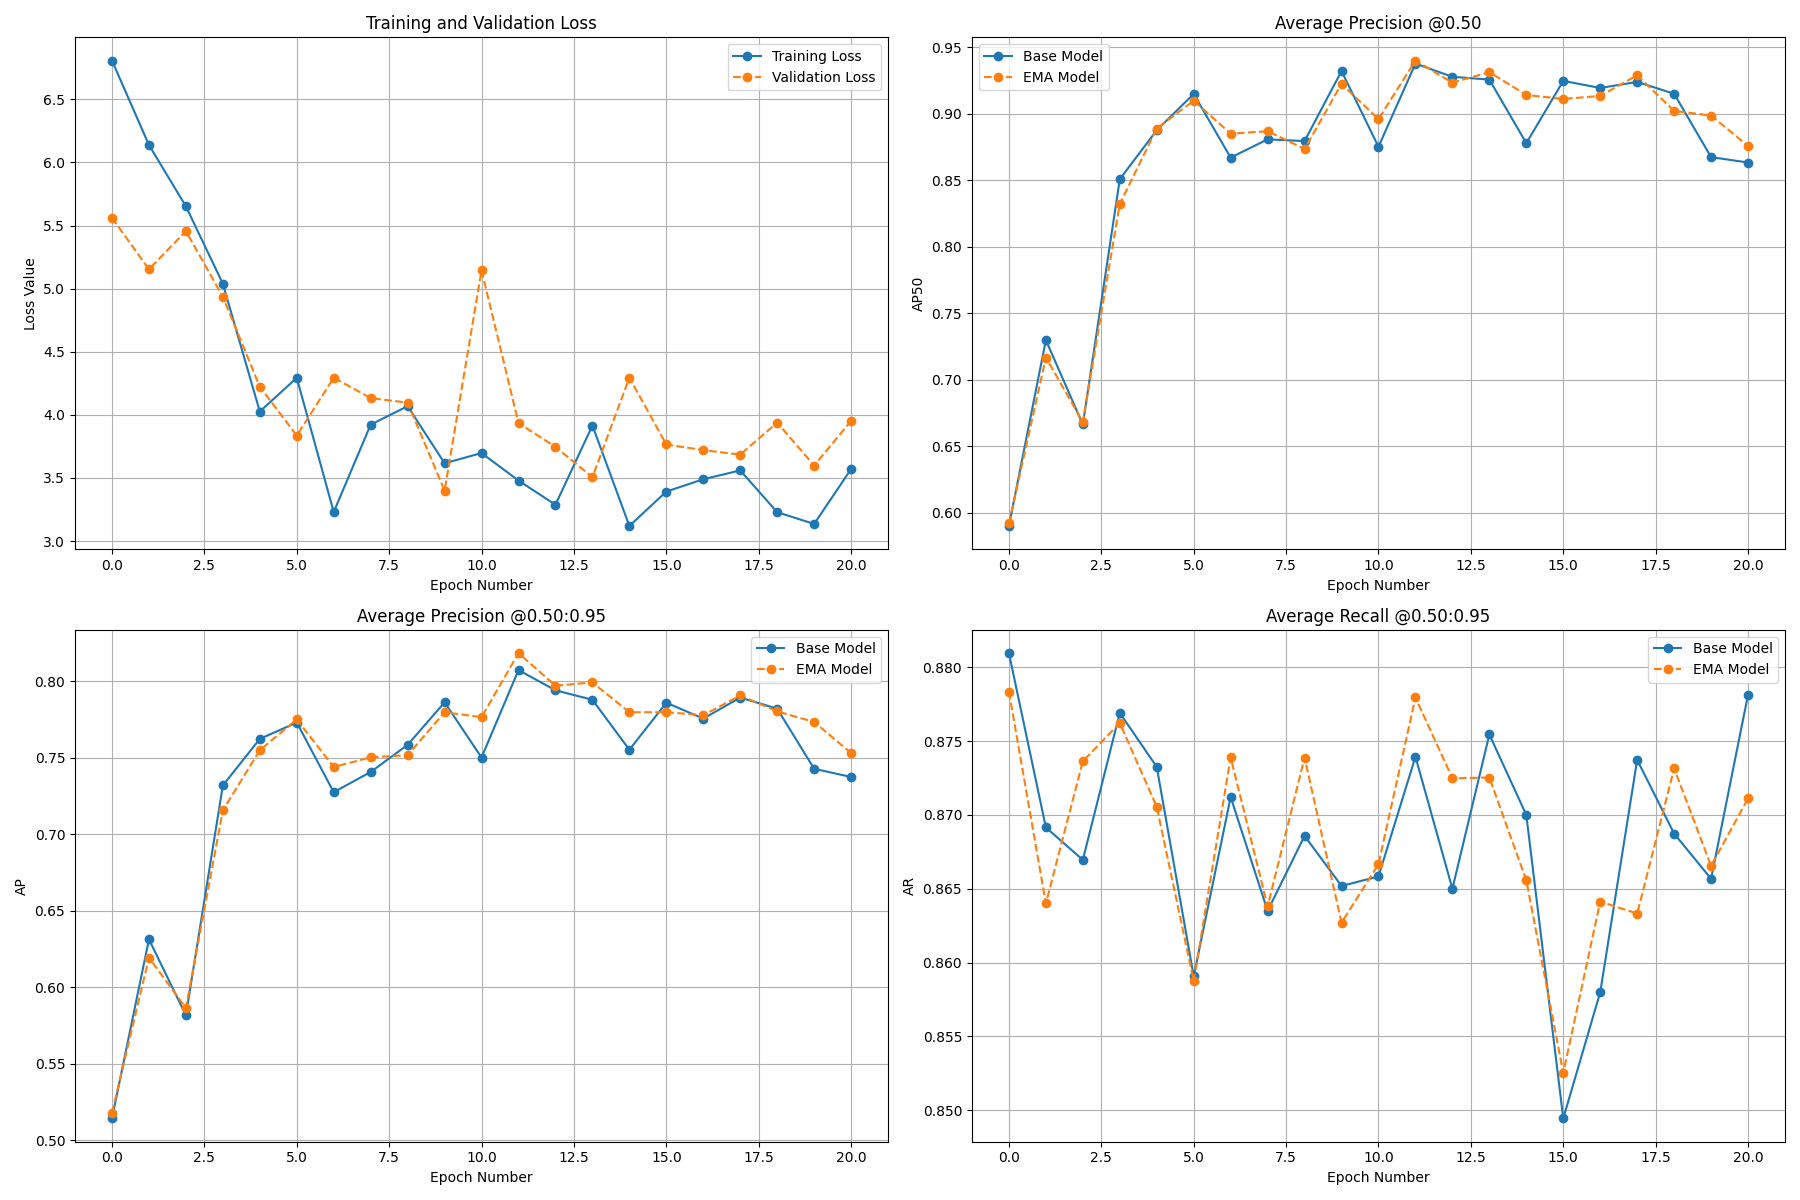

In [ ]:
img = Image.open(f"{CHECKPOINT_DIR}/metrics_plot.png")
img

In [17]:
best_ckpt = f"{CHECKPOINT_DIR}/checkpoint_best_total.pth"

In [18]:
model1 = RFDETRSmall(pretrain_weights=best_ckpt)

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


In [19]:
import supervision as sv

In [20]:
CLASS_NAMES = ["coins", "1", "2", "5", "10", "20"]

In [21]:
import time

In [22]:
def run_inference(image_path, conf=0.5):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  start = time.time()
  predictions = model1.predict(image, confidence=conf)[0]
  fps = 1 / (time.time() - start)
  print(f"FPS: {fps:.2f}")
  # print(predictions)
  labels = [
        f"Coin:{CLASS_NAMES[class_id]}, Conf:{confidence*100:.2f}%"
        for class_id, confidence
        in zip(predictions.class_id, predictions.confidence)
    ]
  # print(labels)

  annotated_image = image.copy()
  annotated_image = sv.BoxAnnotator(color=sv.ColorPalette.ROBOFLOW).annotate(annotated_image, predictions)
  annotated_image = sv.LabelAnnotator(color=sv.ColorPalette.ROBOFLOW).annotate(annotated_image, predictions, labels)

  sv.plot_image(annotated_image)

In [23]:
TEST_DATA_DIR = "/content/coins/test"
test_images = os.listdir(TEST_DATA_DIR)

In [24]:
with open("/content/coins/test/_annotations.coco.json") as f:
    test_coco = json.load(f)

In [25]:
success_samples = random.sample(test_images, 10)

FPS: 0.35


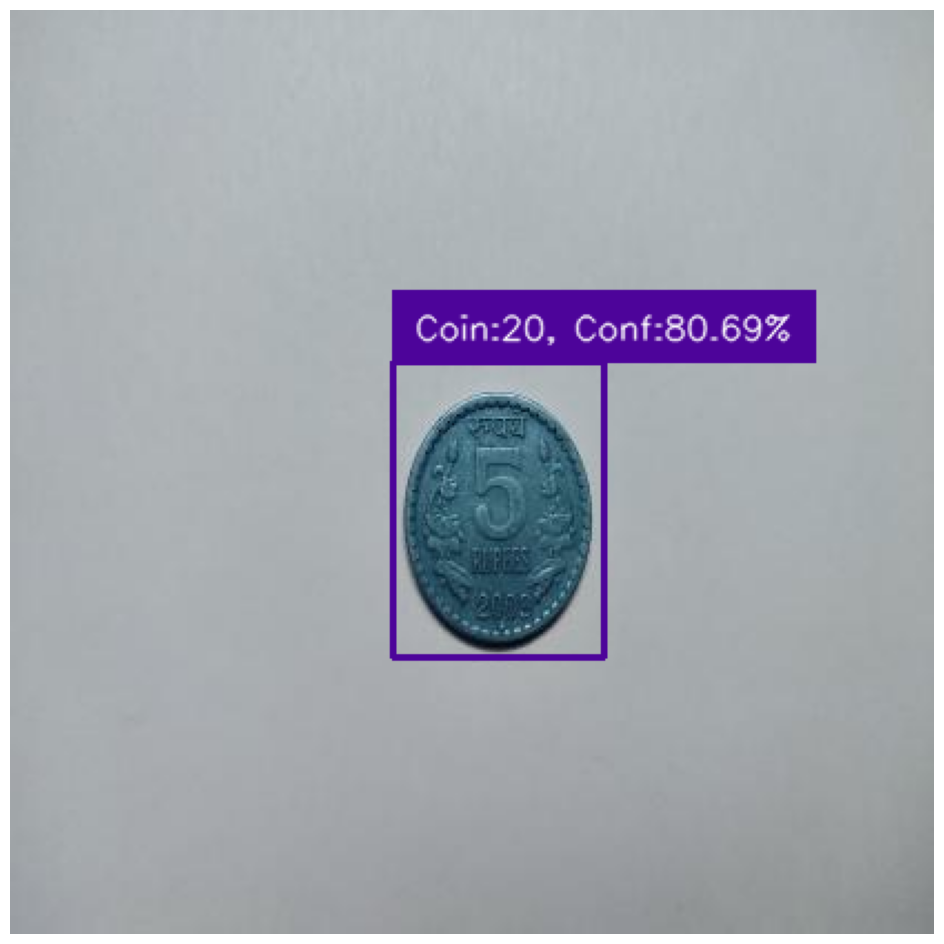

FPS: 18.71


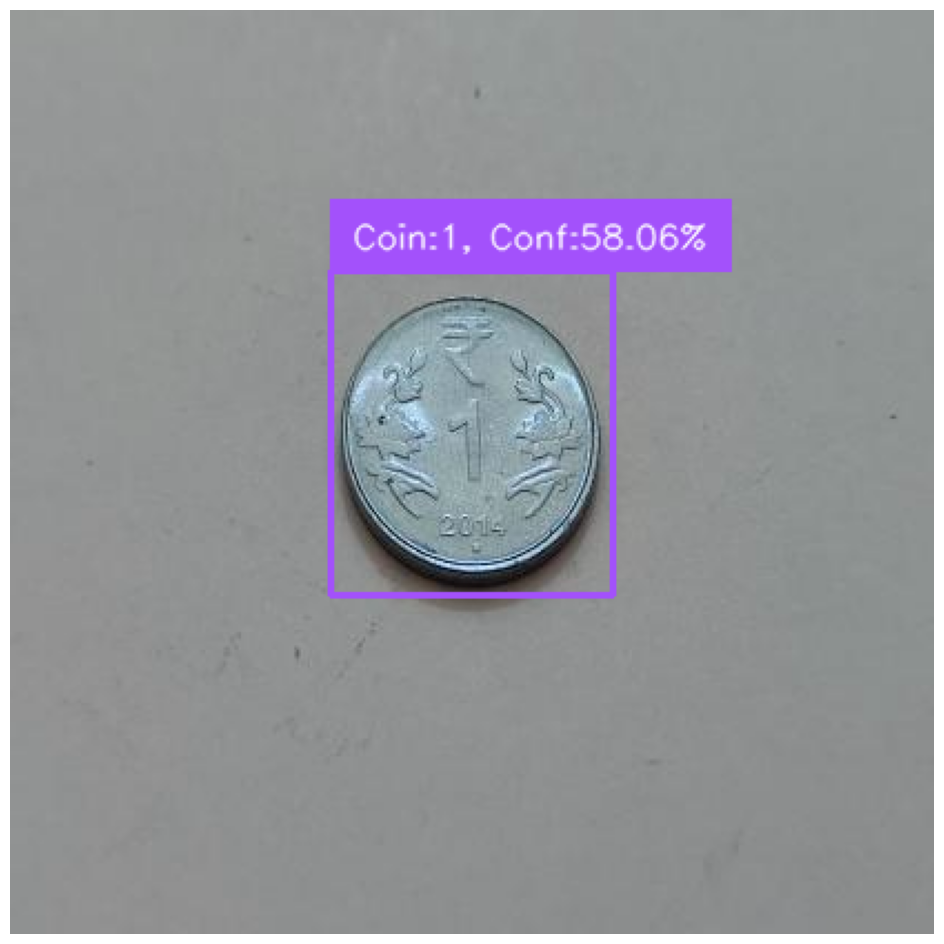

FPS: 18.67


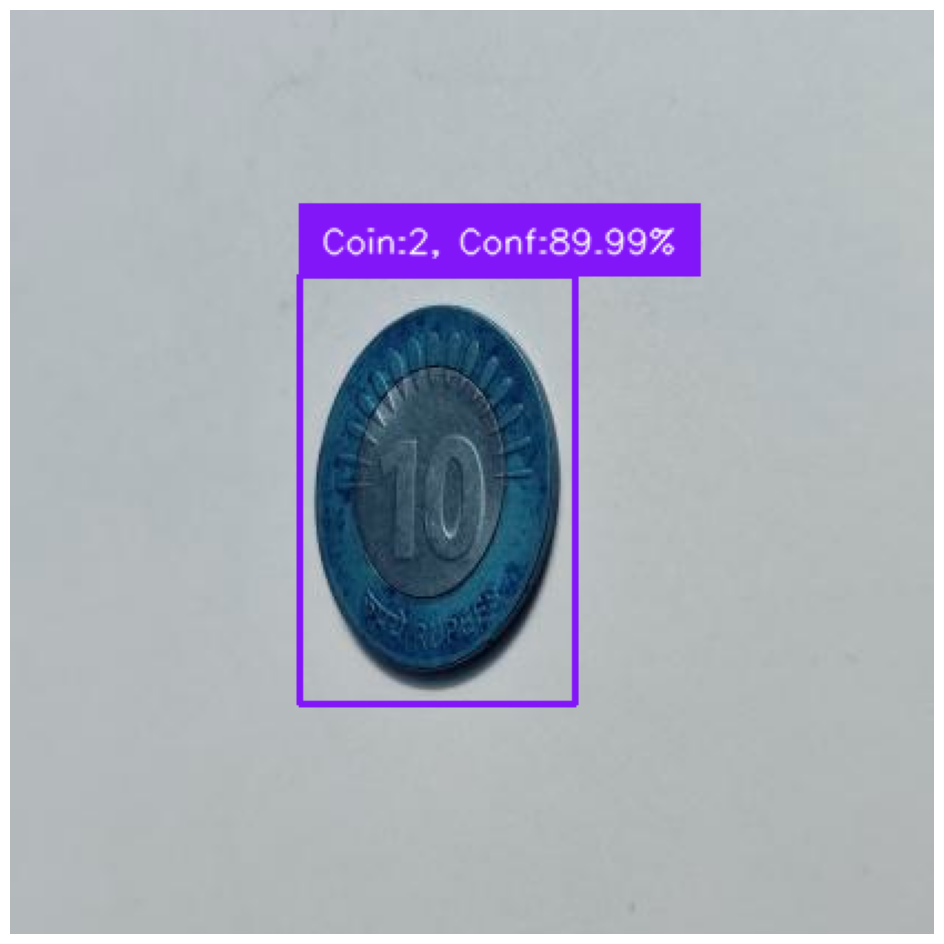

FPS: 17.34


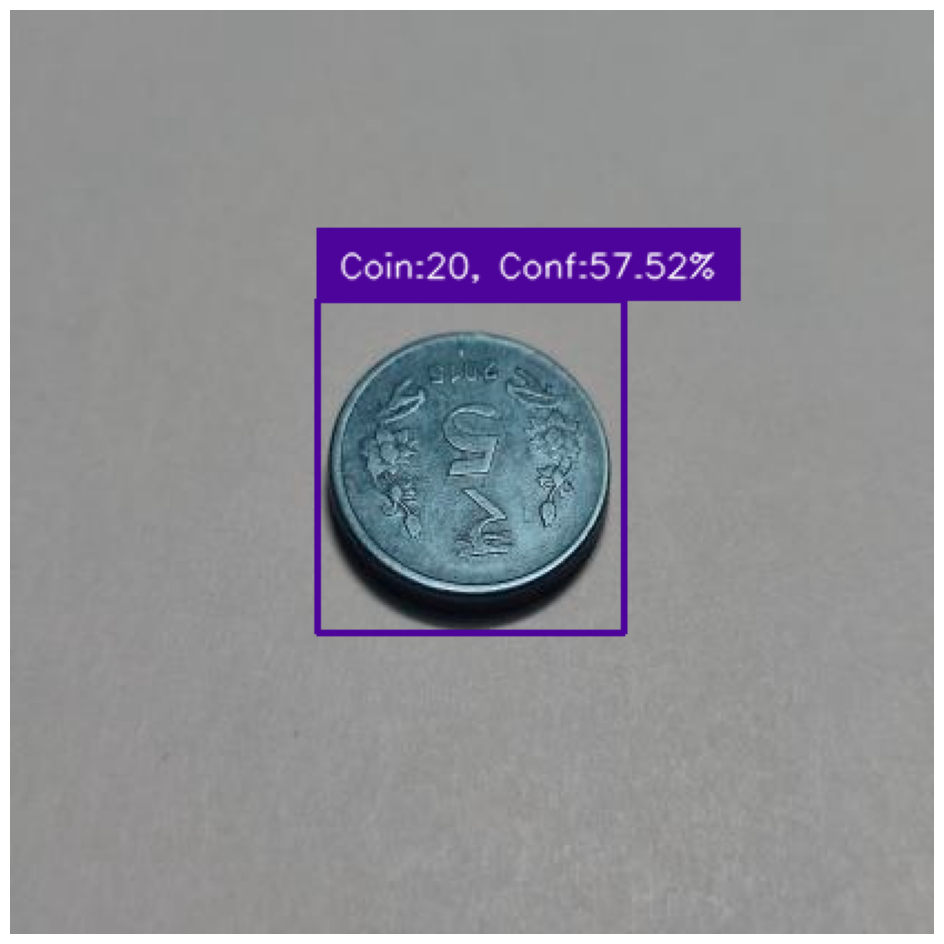

FPS: 18.37


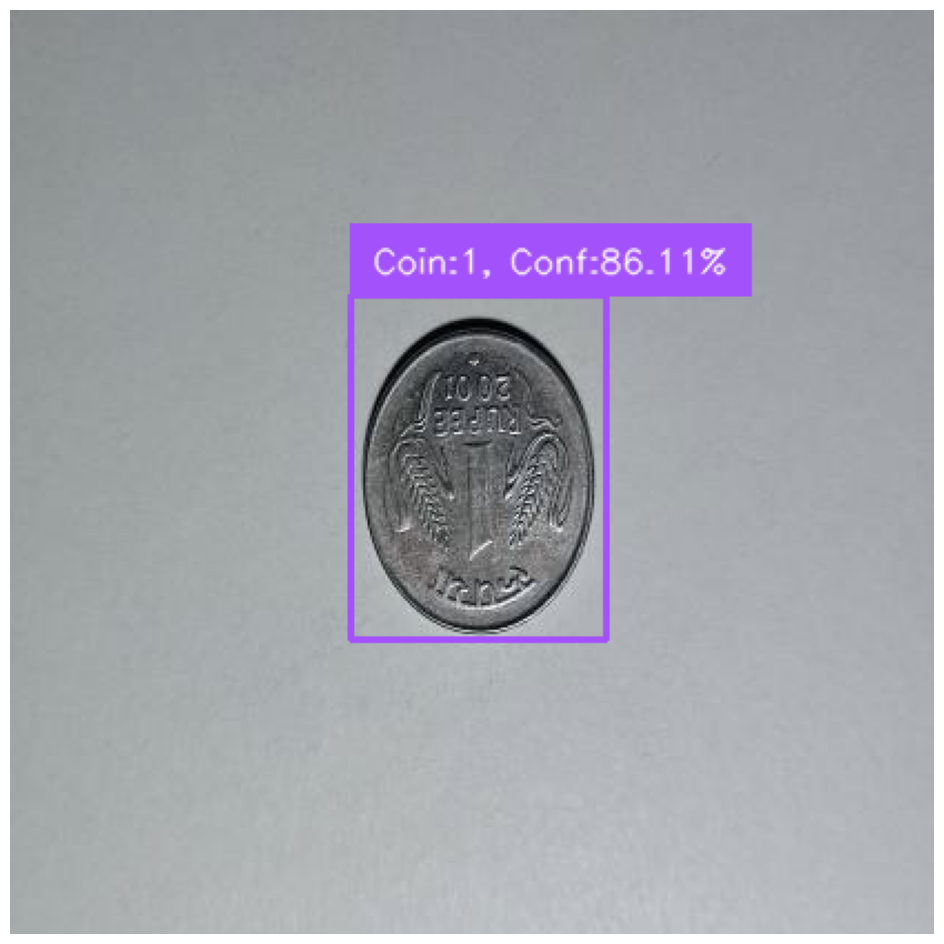

FPS: 19.24


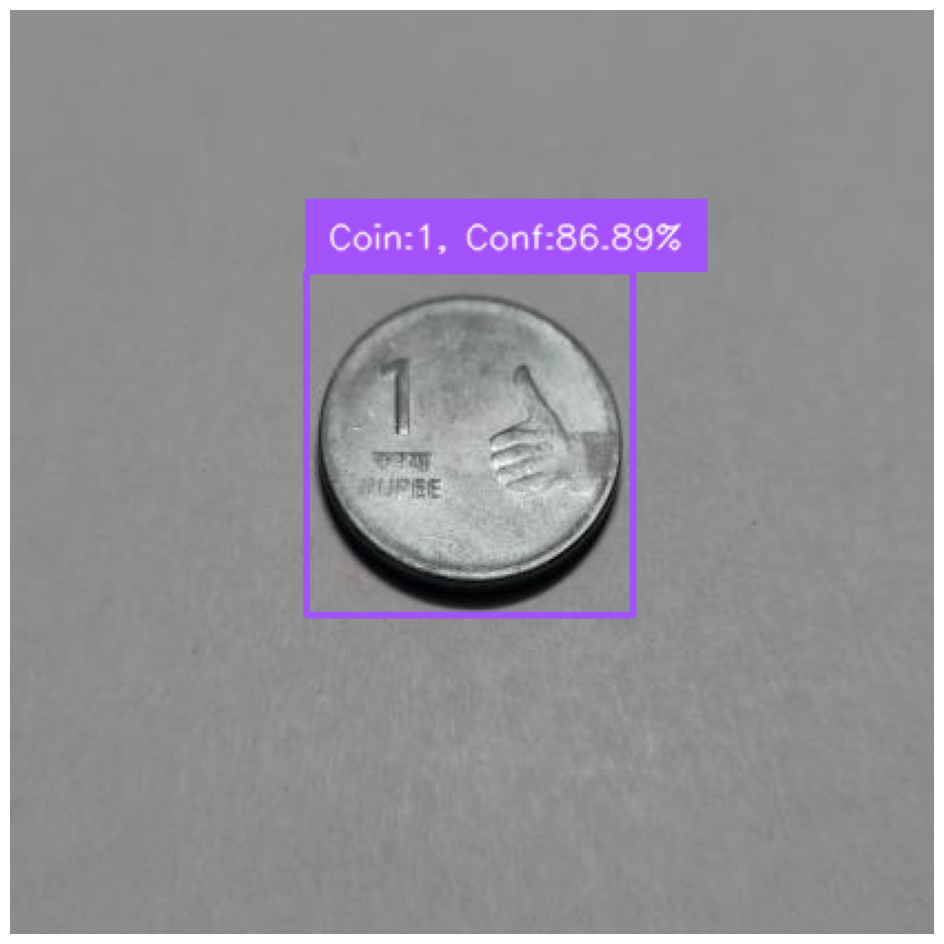

FPS: 19.20


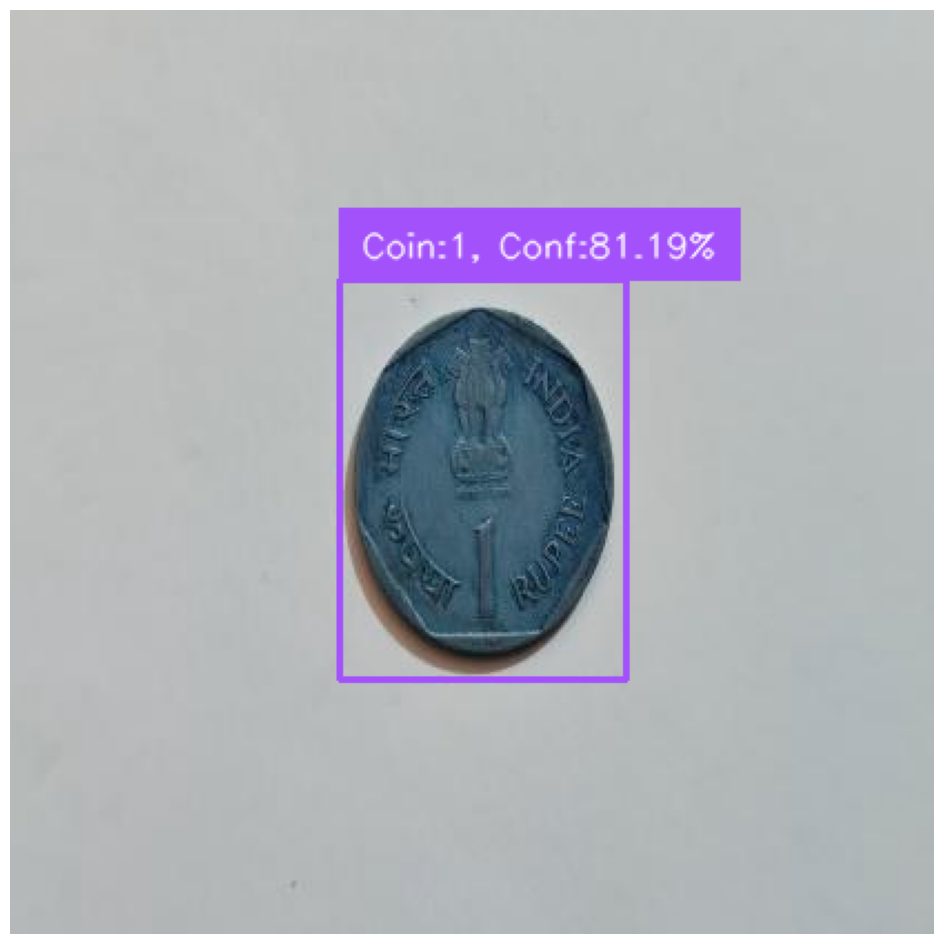

FPS: 18.74


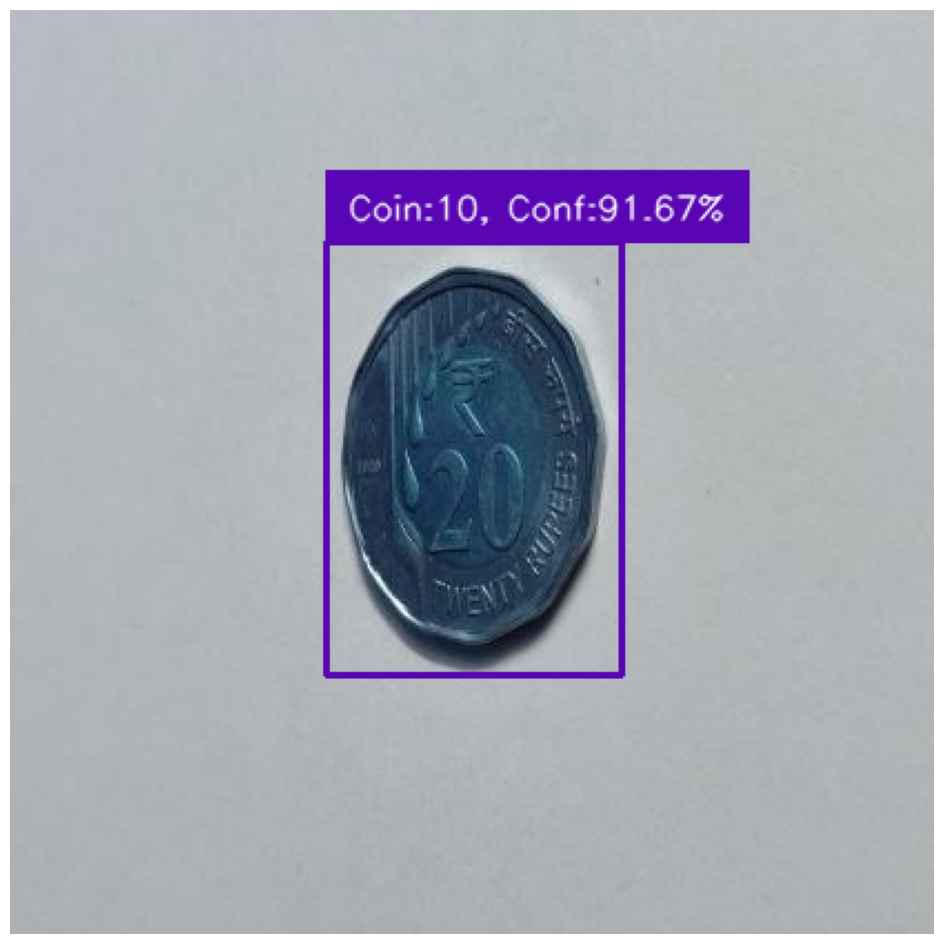

FPS: 17.95


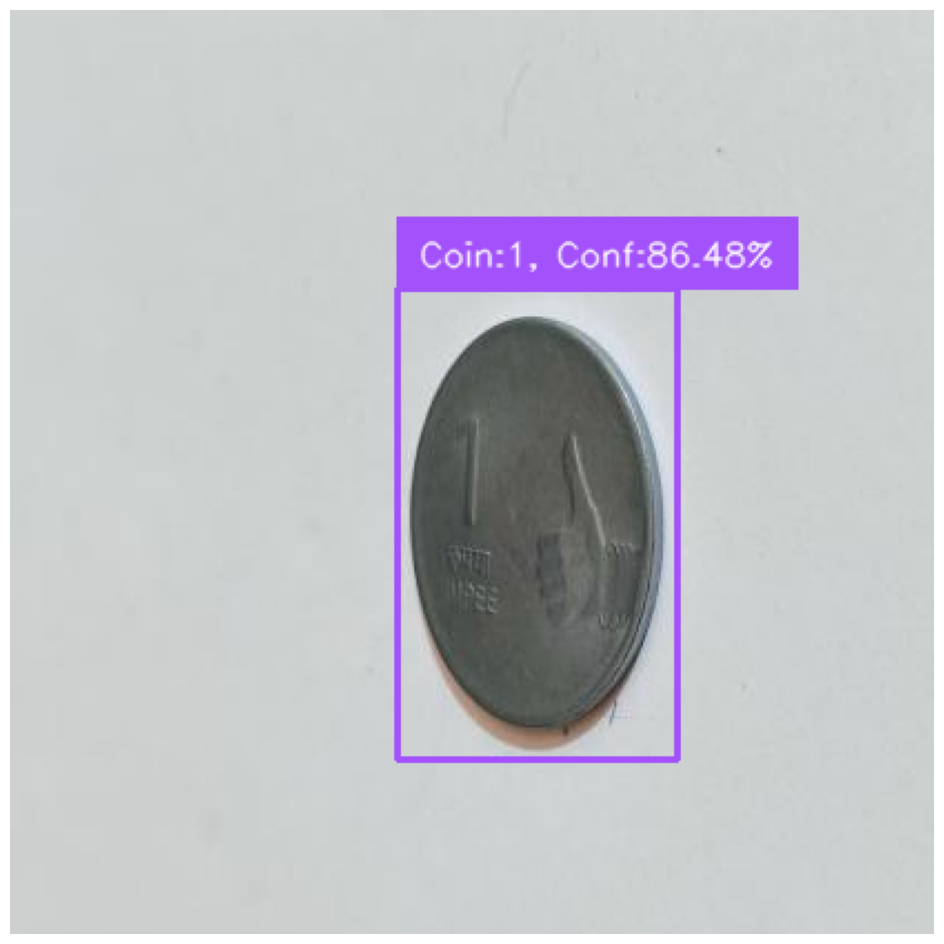

In [26]:

for img_filename in success_samples:
    if img_filename.endswith('.json'):
        continue
    image_path = os.path.join(TEST_DATA_DIR, img_filename)
    run_inference(image_path, conf=0.5)

In [ ]:
a